In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

# Population model

In [64]:
def temperature(t, offset = 0): # Temperature function in kelvin
    return (4*np.cos(2*np.pi*(t + offset)/365.25 + 9.2) + 1828.0) + 273.15

def transition_rate(evt, T, R0, Ha, Hh, T12, R): # Transition rate function from one state to another
    return R0[evt]*(T/298)*np.exp(Ha[evt]*(1/298 - 1/T)/R)/(1 + np.exp(Hh[evt]*(1/T12[evt] - 1/T)/R))

def adult_rate(T, R0, Ha, Hh, T12, R): # Transition rate function from larvae to pupae to adult
    egg_transi = transition_rate(0, T, R0, Ha, Hh, T12, R)
    larvae_transi = transition_rate(1, T, R0, Ha, Hh, T12, R)
    pupae_transi = transition_rate(2, T, R0, Ha, Hh, T12, R)
    death_L = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)
    death_P = 0.01 + 0.9725*np.exp(-0.1*(T - 278)/2.7035)

    return egg_transi*larvae_transi*pupae_transi/((pupae_transi + death_P) * (larvae_transi + death_L))

# definition of the different mortality rates : 
def egg_death(T) : 
    if T < 288 : 
        return 0
    else :
        return 0.011 # A calculer

In [65]:
def mating(M, Ms):
    return M / (1 + M + Ms)

def event(i, state, M_event):
    return state + M_event[i]

def release1(M, n):
    return n*M + 1000

In [66]:
def det_model(y, t, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R):
    E, F, Ff, Fs, M, Ms = y

    T = temperature(t, 100)
    if T < 286:
        death_egg = 0.001
        transi = 0
        deltaA = 2*deltaA

    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + comp * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
        deltaA = 0.091
    
    matf = mating(0.01*M, 0.001*Ms)
    mats = mating(0.001*Ms, 0.01*M)

    # Differential equations
    dE_dt = n_egg * birth * Ff - death_egg * E
    dF_dt = mu * transi * E - (matf + mats + deltaA) * F
    dFf_dt = matf * F - deltaA * Ff
    dFs_dt = mats * F - deltaA * Fs
    dM_dt = (1 - mu) * transi * E - deltaA * M
    dMs_dt = -deltaA * 1.2 * Ms
    return [dE_dt, dF_dt, dFf_dt, dFs_dt, dM_dt, dMs_dt]

def sim(n_intervals, pop_init, days, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R, n_egg=64):
    # Solve the differential equations
    pop0 = pop_init
    E, F, Ff, Fs, M, Ms = [], [], [], [], [], []
    # Divide the time in n_intervals
    taille_intervals = len(days)//n_intervals
    intervals = [days[i * taille_intervals : (i + 1) * taille_intervals] for i in range(n_intervals - 1)] + [days[(n_intervals - 1) * taille_intervals :]]

    for interval in intervals:
        solution = odeint(
            det_model, pop0, interval,
            args=(birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R)
        )
        E0, F0, Ff0, Fs0, M0, Ms0 = solution.T
        E.extend(E0)
        F.extend(F0)
        Ff.extend(Ff0)
        Fs.extend(Fs0)
        M.extend(M0)
        Ms.extend(Ms0)
        
        if interval[-1] > 450 and M[-1] > 1 and temperature(interval[-1]) > 288:
            Ms[-1] = Ms[-1] + release1(M[-1],100)
            #print("release", Ms[-1])

        pop0 = [E[-1], F[-1], Ff[-1], Fs[-1], M[-1], Ms[-1]]
    
    return E, F, Fs, Ff, M, Ms

In [67]:
n_intervals = 1000
intervals = [np.linspace(0, 365, n_intervals), np.linspace(0, 365, n_intervals)]

In [68]:
# Ensure that days and release are defined
days = np.linspace(0, 3600, 36001)  # Time steps
release = np.arange(7, 3600.1, 7)  # Release every week starting from day 7

# Check if any element in days is close to any element in release
result = np.any(np.abs(days[:, None] - release) < 1e-3)
print(result)

True


In [69]:

# Parameters
birth = 0.5  # Birth rate per adult
puberty = 0.83      # transition rate from egg to adult
mu = 0.5    # rate at which egg becomes a female
deltaE = 0.2     # Death rate per egg
deltaA = 0.091  # Death rate per adult
init_egg = 1000  # Starting egg population
init_f0 = 1000 # Starting female population
init_ff = 0 # Starting fertilised female pop
init_fs = 0 # Starting strerile female pop
init_male = 1000 # Starting adult population
init_sterile = 0 # Starting sterile male population
max_time = 500.0     # Maximum simulation time
comp = 0.001 # Carrying capacity

R0 = [0.24, 0.2088, 0.384]
Hh = [100, 55.99, -472.379]
Ha = [10.798, 26.018, 14.931]
T12 = [14.184, 304.6, 148]
R = 8.31446261815324 # Universal gas constant
# Initialize variables

n_intervals = 1000//7
days = np.linspace(0, 1000, 100001)  # Time steps
pop = np.array([init_egg, init_f0, init_ff, init_fs, init_male, init_sterile])  # Initial population

In [70]:
# Run the simulation
E, F, Ff, Fs, M, Ms= sim(n_intervals, pop, days, birth, deltaA, comp, mu, R0 , Ha, Hh , T12, R)
print(max(E), max(F), max(Ff), max(Fs), max(M), max(Ms))
print(min(E), min(F), min(Ff), min(Fs), min(M), min(Ms))

80901.22849629355 18632.381485765025 101660.781761078 204584.63002404998 223217.0684438417 32398047.478823207
983.0005885259604 769.031580657809 0.0 0.0 1000.0 0.0


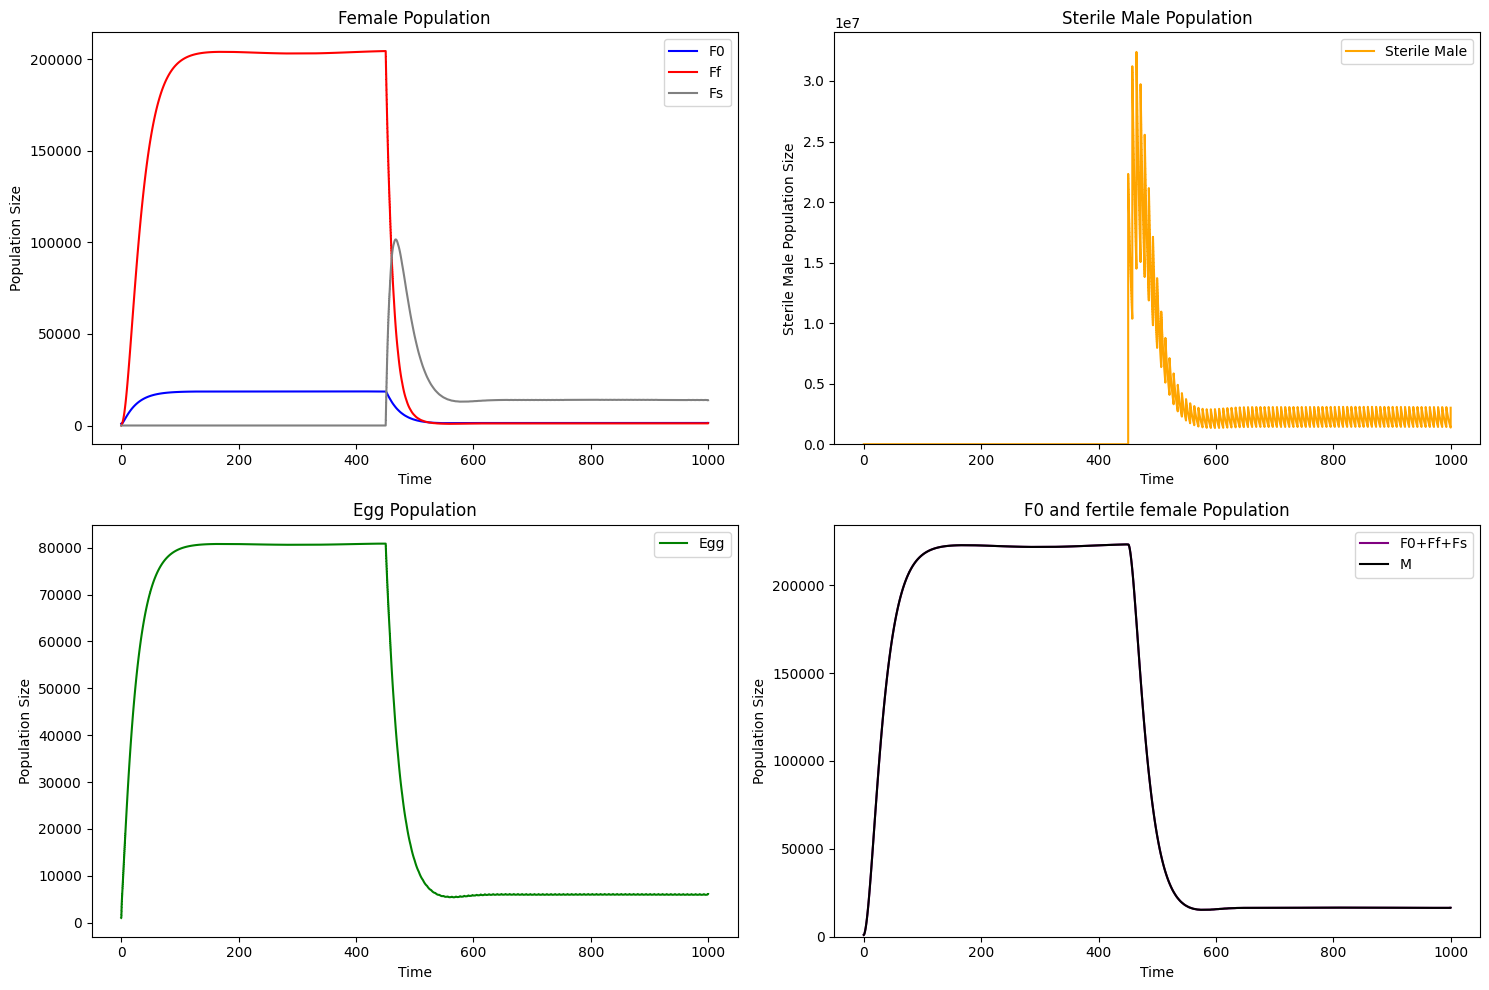

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, F, where="post", label='F0', color = 'blue')
axs[0, 0].step(days, Fs, where="post", label='Ff', color = 'red')
axs[0, 0].step(days, Ff, where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, Ms, where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, E, where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days,[F[i] + Ff[i] + Fs[i] for i in range(len(F))], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, M, where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Stochastic diffusion model

In [72]:
n = 100000
T = 1000
dt = T/n
n_egg = 64
K = 100

In [73]:
def vect_event(X, birth, t, deltaA, comp, mu, R0, Ha, Hh, T12, R):
    E, F, Ff, Fs, M, Ms = X
    T = temperature(t, 100)
    if T < 286:
        death_egg = 0.001
        transi = 0
    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + comp * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
    
    matf = mating(0.01*M, 0.001*Ms)
    mats = mating(0.001*Ms, 0.01*M)


    # Differential equations
    Evt = [math.sqrt(birth * Ff), 
        math.sqrt(death_egg * E),
        math.sqrt(mu * transi * E),
        math.sqrt((1 - mu) * transi * E),
        math.sqrt(matf * F),
        math.sqrt(mats * F),
        math.sqrt(deltaA * F),
        math.sqrt(deltaA * Ff),
        math.sqrt(deltaA * Fs),
        math.sqrt(deltaA * M),
        math.sqrt(deltaA * 1.5 * Ms),]
    return Evt

In [74]:
# Using euler's scheme to solve the differential equations

X = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
X[:, 0] = [init_egg, init_f0, init_ff, init_fs, init_male, init_sterile]
print(X[:, 0])

M = np.array([[n_egg, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, -1, -1, -1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]])

for i in range(0,n):

    U = vect_event(X[:, i], i*dt, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R)
    B = np.array(U) * np.random.normal(0, math.sqrt(dt), 11)
    N = np.dot(M, B)
    X[:, i+1] = np.maximum(X[:, i] + np.array(det_model(X[:, i], i*dt, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R))*dt + N * 1/math.sqrt(K),0)

[1000. 1000.    0.    0. 1000.    0.]


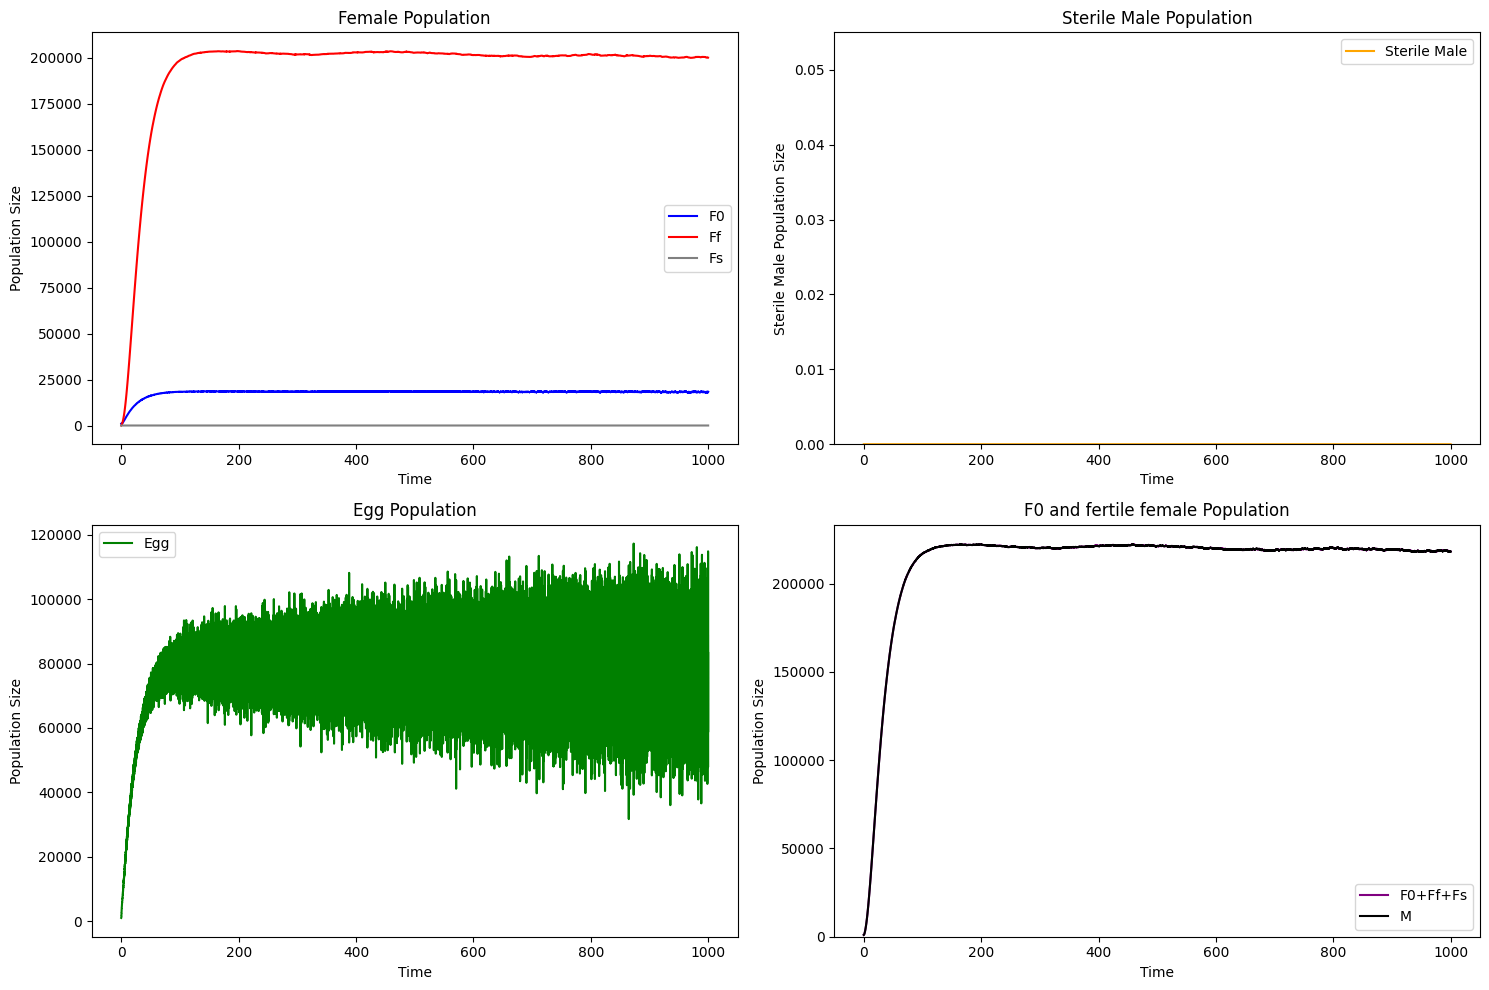

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, X[1], where="post", label='F0', color = 'blue')
axs[0, 0].step(days, X[2], where="post", label='Ff', color = 'red')
axs[0, 0].step(days, X[3], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, X[5], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, X[0], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days, X[1] + X[2] + X[3], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, X[4], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [76]:
def mating(M, Ms):
    return M / (1 + M + Ms)

def matingd1(U, V, u, v):
    return (u + u*v*V )/ (1 + u*U + v*V)**2

def matingd2(U, V, u, v):
    return - (u*v*U )/ (1 + u*U + v*V)**2


In [77]:
def Jac_Mat(X, birth, t, deltaA, comp, mu, R0, Ha, Hh, T12, R):
    E, F, Ff, Fs, M, Ms = X
    T = temperature(t, 100)
    if T < 286:
        death_egg = 0.001
        transi = 0
    else:
        transi = adult_rate(T, R0, Ha, Hh, T12, R)
        death_egg = egg_death(T) + comp * E + (transition_rate(0, T, R0, Ha, Hh, T12, R) - transi)
    
    matf = mating(0.01*M, 0.001*Ms)
    mats = mating(0.001*Ms, 0.01*M)

    d11 = matingd1(M, Ms, 0.01, 0.001)
    d12 = matingd2(M, Ms, 0.01, 0.001)

    d21 = matingd1(Ms, M, 0.001, 0.01)
    d22 = matingd2(Ms, M, 0.001, 0.01)

    # Jacobian matrix
    Jacobian = [[-(death_egg + transi), 0, n_egg*birth, 0, 0, 0,],
           [mu*transi, -deltaA - matf - mats, 0, 0, - d11 - d21, -d12 - d22],
        [0, matf, -deltaA, 0, d11, d12],
        [0, mats, 0, -deltaA, d21, d22],
        [(1 - mu)*transi, 0, 0, 0, -deltaA, 0],
        [0, 0, 0, 0, 0, -deltaA*1.5]]
    return Jacobian

In [81]:
# Using euler's scheme to solve the differential equations

X = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
X[:, 0] = [init_egg, init_f0, init_ff, init_fs, init_male, init_sterile]
V = np.array([np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1), np.zeros(n+1)])
print(X[:, 0])
print(V[:, 0])

M = np.array([[n_egg, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, -1, -1, -1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]])

for i in range(0,n):

    J = Jac_Mat(X[:, i], birth, i*dt, deltaA, comp, mu, R0, Ha, Hh, T12, R)
    U = vect_event(X[:, i], i*dt, birth, deltaA, comp, mu, R0, Ha, Hh, T12, R)
    B = np.array(U) * np.random.normal(0, math.sqrt(dt), 11)
    N = np.dot(M, B)
    V[:, i+1] = V[:, i] + np.dot(J, V[:, i])*dt + N
    X[:, i+1] = np.maximum(X[:, i] + np.array(det_model(X[:, i], i*dt, birth, n_egg, deltaA, comp, mu, R0, Ha, Hh, T12, R))*dt + V[:, i+1] * 1/math.sqrt(K),0)

[1000. 1000.    0.    0. 1000.    0.]
[0. 0. 0. 0. 0. 0.]


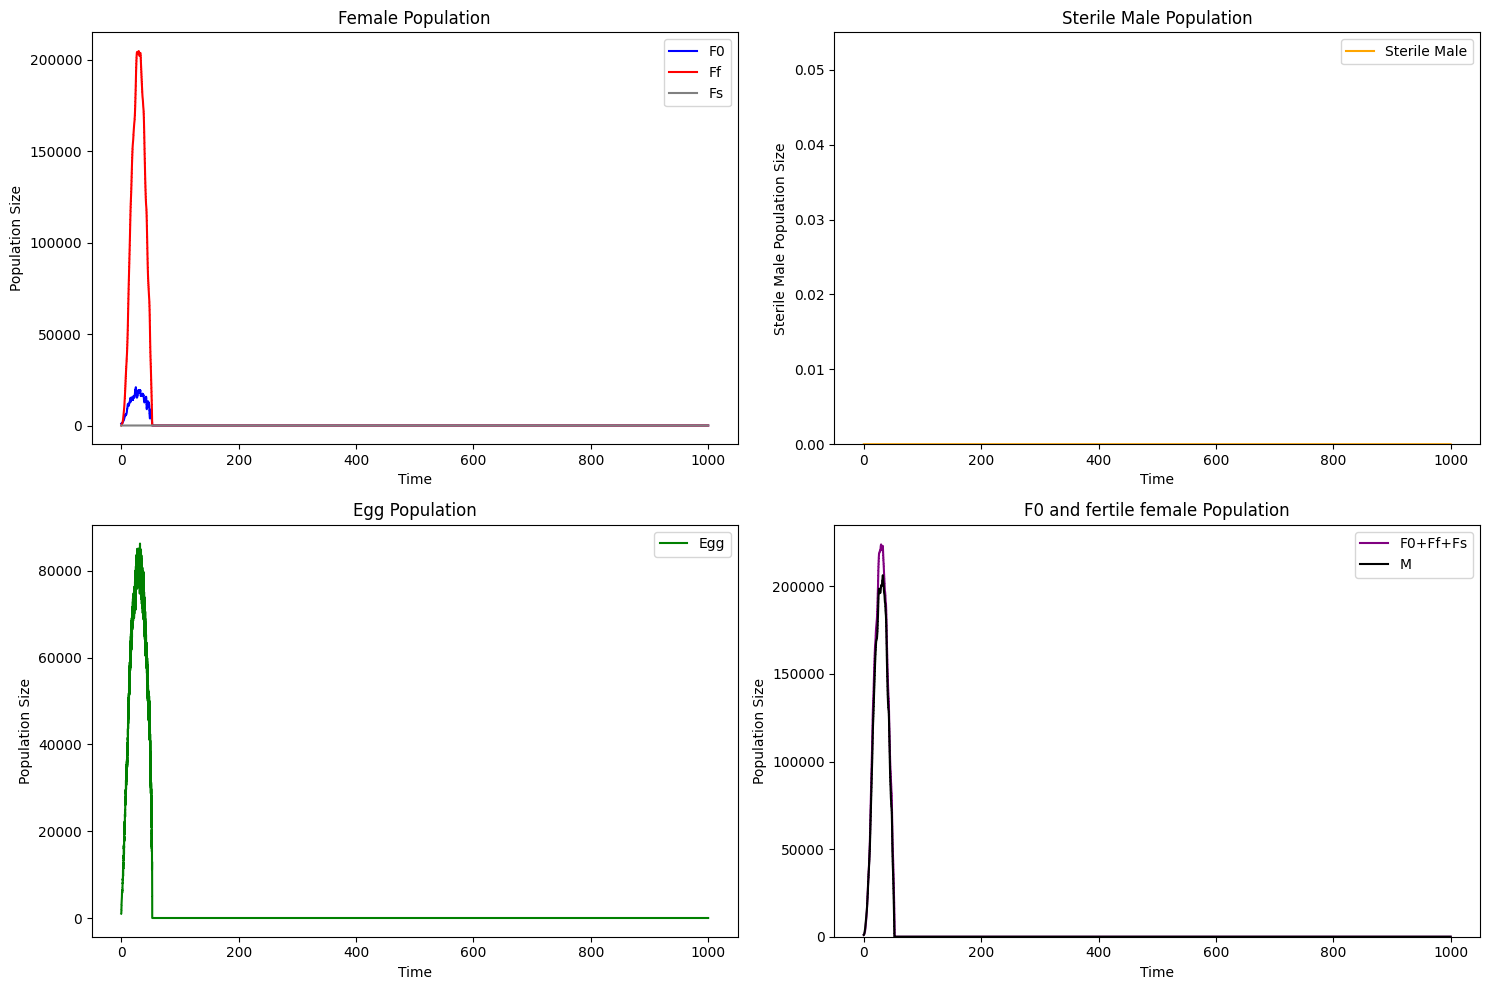

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
temp = temperature(np.array(days), 100)
# Plot results for male and female population
axs[0, 0].step(days, X[1], where="post", label='F0', color = 'blue')
axs[0, 0].step(days, X[2], where="post", label='Ff', color = 'red')
axs[0, 0].step(days, X[3], where="post", label='Fs', color = 'grey')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Population Size')
axs[0, 0].set_title('Female Population')
axs[0, 0].legend()

# Plot results for sterile male population
axs[0, 1].step(days, X[5], where="post", label='Sterile Male', color='orange')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Sterile Male Population Size')
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].set_title('Sterile Male Population')
axs[0, 1].legend()

# Plot results for egg population
axs[1, 0].step(days, X[0], where="post", label='Egg', color='green')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Population Size')
axs[1, 0].set_title('Egg Population')
axs[1, 0].legend()

axs[1, 1].step(days, X[1] + X[2] + X[3], where="post", label='F0+Ff+Fs', color='purple')
axs[1, 1].step(days, X[4], where="post", label='M', color='black')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Population Size')
axs[1, 1].set_ylim(bottom=0)
axs[1, 1].set_title('F0 and fertile female Population')
axs[1, 1].legend()

plt.tight_layout()
plt.show()
